In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
import semopy as sem
from semopy import inspector
from tqdm.notebook import tqdm
from glob import glob
import warnings

In [8]:
import covid_commons as g
from covid_commons import peek
g = reload(g)

# General

## Prepare data

In [9]:
cities = g.load_cities()
nyc = cities['nyc']
chi = cities['chi']

In [10]:
il = g.City('il', {
    'name': 'Illinois',
    'events': {},
    'counties': {x[-3:]: [17, int(x[-3:])] for x in
                 glob(g.DATA_DIR+'/county_wise/17/*')}
})

In [11]:
nyc.name = 'NYC'
nyc.fullname = 'New York City'
chi.fullname = 'Chicago'
il.fullname = 'Illinois'
nyc.color = 'dodgerblue'
chi.color = 'blueviolet'
il.color = 'tomato'

### Read data

In [12]:
def read_modelX(city):
    X = pd.read_csv(city.dir + '/zip_modelX.csv')
    X['date'] = g.str2date(X['date'])
    X['week'] = g.get_week(X['date'])
    X['is_weekend'] = (X['date'].dt.dayofweek // 5 == 1).astype(int)
    X['norm_income'] = g.range_norm(X['income'])
    X['time_home'] /= 24
    # add a small value to prevent non-PD error in sample covariance matrix
    X[['log_cases', 'log_tests', 'log_cases_prev', 'log_tests_prev']] += 0.001
    return X

### Get window data

In [13]:
def get_win_data_daily(X, win_size=7,
                       agg={'tot_cei': sum, 'prop_home': np.mean,
                            'time_home': np.average, 'cases': sum},
                       log_transform=['tot_cei', 'cases']):
    """
    Get the rolling window aggregated values of the variables of Xnyc.
    """
    df = (X.set_index(['date'])
            [['zip'] + list(agg.keys())]
            .groupby('zip')
            .rolling(win_size).agg(agg)
            .dropna()
            .sort_index()
            .rename(columns=lambda x: x + '_win'))
    for var in log_transform:
        # add a small term to prevent division by zero error
        df['log_'+var+'_win'] = np.log(1 + df[var+'_win']).clip(0.001)
    X = (X.set_index(['zip', 'date'])
         .join(df, how='inner')
         .reset_index()
         .set_index(['zip', 'week', 'date'])
         .reset_index()
        )
    return X

### Add phase column
Based on visualization

In [14]:
def plot_sem_phases(X, dates, colors):
    ax = (X.groupby('date')['cases'].sum().plot(figsize=(5, 3)))
    plt.title('Daily cases in NYC (starting 2 Apr)', fontsize=15)
    plt.ylabel('No. of cases', fontsize=13)
    plt.xlabel('')
    for i, date in enumerate(dates[:-1]):
        start = g.int2date(date)
        end = g.int2date(dates[i+1]) - pd.DateOffset(days=1)
        ax.axvspan(start, end, color=colors[i], alpha=0.1)
        ax.text(start + pd.DateOffset(days=2), 0, start.strftime('%d %b'),
                rotation=90, color='black')

## SEM model

### Variables

In [15]:
frac_vars = 'frac_poor + frac_old + frac_low_edu + frac_black + frac_transit'

- $S_i$: census_vars (log_income + frac_poor + frac_black + frac_old + frac_transit + frac_low_edu)
- $I_t$: is_weekend
- $y_{i,t}$: log_cases
- $y_{i,w}$: log_cases_win
- $\tau_{i,t}$: log_tests
- $P_{i,t}$: prop_home
- $P_{i,w}$: prop_home_win
- $T_{i,t}$ time_home
- $T_{i,w}$: time_home_win
- $E_{i,t}$: log_tot_cei
- $E_{i,w}$: log_tot_cei_win

### SEM model

In [16]:
def sem_model(formula, data, identifier):
    model = sem.Model(formula)
    model.load_dataset(data)
    opt = sem.optimizer.Optimizer(model)
    opt.optimize()
    params = inspector.inspect(opt)
    params.insert(0, 'case', identifier)
    return params

### Weekly SEM

In [17]:
def weekly_sem(X, formula, bin_size=7):
    res = []
    X = X[X['week'] >= g.int2date(200330)]
    for wk, df in X.groupby('week'):
        try:
            params = sem_model(formula, df, wk)
            res.append(params)
        except np.linalg.LinAlgError:
            print('LinAlgError in ' + wk.strftime('%Y-%m-%d'))
    res = pd.concat(res).reset_index(drop=True)
    return res

### Daily SEM

In [18]:
def daily_sem(X, formula, bin_size=7, start_date=200402):
    res = []
    X = X[X['date'] >= g.int2date(start_date)]
    for date, df in tqdm(X.groupby('date')):
        try:
            params = sem_model(formula, df, date)
            res.append(params)
        except np.linalg.LinAlgError:
            print('LinAlgError in ' + date.strftime('%Y-%m-%d'))
    res = pd.concat(res).reset_index(drop=True)
    return res

### Phased SEM

In [19]:
def phased_sem(Xwin, formula, win_size=7):
    """
    Get the window-based SEM models trained in phases.
    """
    X = (Xwin.drop(columns=['week'])
         .set_index(['zip', 'phase', 'date'])
         .add(0.001) # to prevent division by zero error
         .reset_index()
        )
    res = []
    for week, panel in X.groupby('phase'):
        try:
            res.append(sem_model(formula, panel, week))
        except np.linalg.LinAlgError:
            print('LinAlgError in ' + week.strftime('%Y-%m-%d'))
    res = pd.concat(res).replace('-', np.nan).astype({'p-value': float}).reset_index(drop=True)
    return res

### Get parameters

In [20]:
def get_params_table(df, imp_pairs=None, drop_cols=None, outfile=None):
    """
    Make the parameter estimates presentable.
    @param df: <pd.df> table containing parameter estimates indexed by
    (indep. var, depend. var)
    @param imp_pairs: <[(y,x)]> variable pairs whose estimates are to be shown
    """
    df = (df.assign(p_value_label = lambda x:
                    pd.cut(x['p-value'], [-0.1, 0.001, 0.01, 0.05, 0.1, 1]).cat.codes
                    .map({0: '***', 1: '**', 2: '*', 3: '(.)', 4: '(x)'}))
          .assign(estimate = lambda x: x['Estimate'].map('{:.3f}'.format) +
                  ' ' + x['p_value_label'])
          .pivot(index=['lval', 'rval'], columns='case', values='estimate')
          .rename_axis(columns='phase'))
    if not imp_pairs is None:
        df = df.loc[imp_pairs]
    if not drop_cols is None:
        df = df.drop(columns=drop_cols)
    if not outfile is None:
        df.to_csv(outfile)
    return df

### Visualize parameters

In [21]:
def plot_estimate_trend(params, var_pairs, kind='date',
                        max_coeff=5, max_std_err=1.5, max_pct_diff=50,
                        figsize=(7, 4), rolling_win=1,
                        interpolate_thresh=np.nan,
                        marker='o', evts=[('', 200518)]):
    fig, ax = plt.subplots(figsize=figsize)
    for xvar, yvar, color in var_pairs:
        df = (params.query(f'lval == "{yvar}" & rval == "{xvar}"')
              .set_index('case')
              .rename_axis(kind)
              .replace('-', np.nan))
        df['std_err'] = np.clip(df['Std. Err'], 0, max_std_err)
        df['pct_diff'] = (df['Estimate'].diff()/df['Estimate'])*100
        adjust_dates = (df[(np.abs(df.pct_diff) > max_pct_diff) &
                           (np.abs(df.Estimate) > max_coeff)].index)
        for date in adjust_dates:
            idx = df.index.get_loc(date)
            prev, next_ = df.iloc[idx-1], df.iloc[idx+1]
            df.loc[date, 'Estimate'] = 0.5*(prev['Estimate'] + next_['Estimate'])
            df.loc[date, 'std_err'] = 0.5*(prev['std_err'] + next_['std_err'])
        df['Estimate'] = df['Estimate'].rolling(rolling_win).mean()
        df['std_err'] = df['std_err'].rolling(rolling_win).mean()
        ax.plot(df['Estimate'], marker=marker, color=color,
                label=f'{yvar} ~ {xvar}')
        y1 = (df['Estimate'] - df['std_err']).values
        y2 = (df['Estimate'] + df['std_err']).values
        ax.fill_between(df.index.values,
                        list((df['Estimate'] - df['std_err'])),
                        list(df['Estimate'] + df['std_err']),
                        color=color, alpha=0.1, interpolate=True)
        ax.legend(fontsize=10)
    ax.xaxis.set_major_locator(mpl.dates.WeekdayLocator(
        byweekday=0, interval=1))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d %b'))
    plt.xticks(rotation=45)
    plt.title(f'Variation of SEM coefficients in NYC by {kind}')
    plt.ylabel('Coefficient')
    plt.axhline(0, ls='--', color='darkgrey')
    for evt_name, date in evts:
        ax.axvline(g.int2date(date), color='grey', ls='--', lw=0.8)
        ax.text(g.int2date(date), ax.get_ylim()[1], evt_name,
                ha='right', va='top', rotation=90)
    return df

# NYC

## Prepare data

In [22]:
nyc.X = read_modelX(nyc)
peek(nyc.X)

Shape: (17141, 31), Memory: 4.054 MB


,zip,date,exp_visits,tot_cei,avg_cei,tot_dev,prop_home,time_home,frac_poor,frac_low_edu,...,log_cases,log_cases_prev,log_tests,log_tests_prev,log_income,log_tot_cei_lag,log_tot_cei_lag_prev,week,is_weekend,norm_income
0,10001,2020-03-09,13530,14326.611,1.058877,2007,0.240538,0.249503,0.532339,0.278937,...,0.001,0.001,0.001,0.001,5.153979,9.619134,8.753734,2020-03-09,0,0.499372
1,10001,2020-03-10,12271,12760.898,1.039923,1840,0.256926,0.329704,0.532339,0.278937,...,0.001,0.001,0.001,0.001,5.153979,9.736945,9.619134,2020-03-09,0,0.499372
2,10001,2020-03-11,11546,10708.291,0.927446,1702,0.264240,0.345748,0.532339,0.278937,...,0.001,0.001,0.001,0.001,5.153979,9.637962,9.736945,2020-03-09,0,0.499372


### Add phases

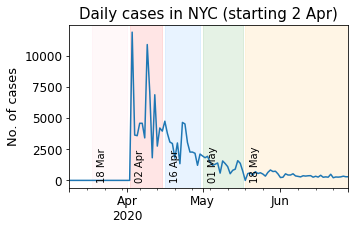

In [23]:
plot_sem_phases(nyc.X, dates=[200318, 200402, 200416, 200501, 200518, 200630],
                colors=['pink', 'red', 'dodgerblue', 'green', 'orange'])

In [24]:
nyc.X['phase'] = (pd.cut(g.date2int(nyc.X['date']),
                     [200301, 200402, 200416, 200501, 200518, 200701]
                    ).cat.codes).astype('category')

### Get window data

In [25]:
%%time
nyc.Xwin = get_win_data_daily(nyc.X)
peek(nyc.Xwin)

Shape: (16211, 38), Memory: 4.592 MB
CPU times: user 3.81 s, sys: 68.4 ms, total: 3.88 s
Wall time: 3.99 s


,zip,week,date,exp_visits,tot_cei,avg_cei,tot_dev,prop_home,time_home,frac_poor,...,log_tot_cei_lag_prev,is_weekend,norm_income,phase,tot_cei_win,prop_home_win,time_home_win,cases_win,log_tot_cei_win,log_cases_win
0,10001,2020-03-09,2020-03-15,2525,951.26807,0.376740,1614,0.297833,0.181453,0.532339,...,9.389172,1,0.499372,0,53144.24987,0.268758,0.267691,0.0,10.880784,0.001
1,10001,2020-03-16,2020-03-16,4306,1784.95700,0.414528,1651,0.292373,0.148296,0.532339,...,8.718683,0,0.499372,0,40602.59587,0.276163,0.253233,0.0,10.611612,0.001
2,10001,2020-03-16,2020-03-17,3542,1541.17810,0.435115,1651,0.303269,0.166567,0.532339,...,9.569943,0,0.499372,0,29382.87597,0.282784,0.229928,0.0,10.288201,0.001


## Static SEM

## Weekly

### NYC:W1 (form=1, w=0, log=True)

### NYC:W2 (form=2, w=0, log=True)

### NYC:W3

### NYC:W4

In [26]:
%%time
nyc.W4 = weekly_sem(nyc.Xwin, f'''
    eta_win ~ log_income + {frac_vars}
    log_income ~~ frac_poor
    log_income ~~ frac_old
    log_income ~~ frac_low_edu
    log_income ~~ frac_black
    log_income ~~ frac_transit
    frac_poor ~~ frac_old
    frac_poor ~~ frac_low_edu
    frac_poor ~~ frac_black
    frac_poor ~~ frac_transit
    frac_old ~~ frac_low_edu
    frac_old ~~ frac_black
    frac_old ~~ frac_transit
    frac_low_edu ~~ frac_black
    frac_low_edu ~~ frac_transit
    frac_black ~~ frac_transit
    eta_win =~ log_tot_cei_win + prop_home_win + time_home_win
    prop_home_win ~~ time_home_win
    time_home_win ~~ log_tot_cei_win
    log_tot_cei_win ~~ prop_home_win
    log_cases ~ log_cases_win + eta_win
    ''')
peek(nyc.W4)

LinAlgError in 2020-06-22
Shape: (408, 8), Memory: 0.129 MB
CPU times: user 22.3 s, sys: 5.03 s, total: 27.4 s
Wall time: 5.16 s


,case,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,2020-03-30,eta_win,~,log_income,-0.204282,0.0440134,-4.64136,3.46122e-06
1,2020-03-30,eta_win,~,frac_poor,-3.693940,0.68546,-5.38899,7.08548e-08
2,2020-03-30,eta_win,~,frac_old,0.358280,0.111378,3.21681,0.00129626


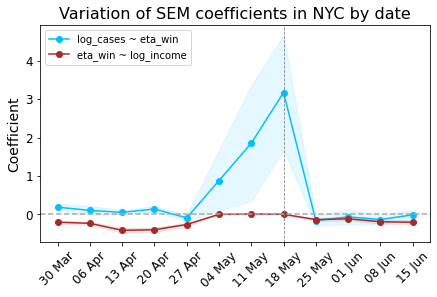

In [27]:
_ = plot_estimate_trend(nyc.W4, [('eta_win', 'log_cases', 'deepskyblue'),
                             ('log_income', 'eta_win', 'brown')])

## Daily

### NYC:D1

In [28]:
%%time
nyc.D1 = daily_sem(nyc.Xwin, f'''
    eta_win ~ log_income + {frac_vars}
    log_income ~~ frac_poor
    log_income ~~ frac_old
    log_income ~~ frac_low_edu
    log_income ~~ frac_black
    log_income ~~ frac_transit
    frac_poor ~~ frac_old
    frac_poor ~~ frac_low_edu
    frac_poor ~~ frac_black
    frac_poor ~~ frac_transit
    frac_old ~~ frac_low_edu
    frac_old ~~ frac_black
    frac_old ~~ frac_transit
    frac_low_edu ~~ frac_black
    frac_low_edu ~~ frac_transit
    frac_black ~~ frac_transit
    eta_win =~ time_home_win + prop_home_win + log_tot_cei_win
    prop_home_win ~~ time_home_win
    time_home_win ~~ log_tot_cei_win
    log_tot_cei_win ~~ prop_home_win
    log_cases ~ log_cases_prev + eta_win
    ''')
peek(nyc.D1)


Shape: (2992, 8), Memory: 0.945 MB
CPU times: user 1min 38s, sys: 21.6 s, total: 2min
Wall time: 23.7 s


,case,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,2020-04-02,eta_win,~,log_income,-0.217475,0.0600576,-3.62111,0.000293337
1,2020-04-02,eta_win,~,frac_poor,-3.742439,0.474526,-7.88669,3.10862e-15
2,2020-04-02,eta_win,~,frac_old,0.286044,0.223164,1.28176,0.199926


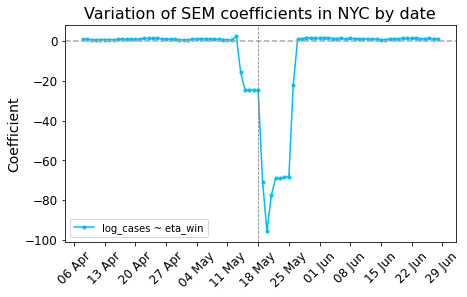

In [29]:
_ = plot_estimate_trend(nyc.D1, [('eta_win', 'log_cases', 'deepskyblue')], marker='.', rolling_win=7)

### NYC:D2

In [30]:
%%time
nyc.D2 = daily_sem(nyc.Xwin, f'''
    eta_win ~ log_income + {frac_vars}
    log_income ~~ frac_poor
    log_income ~~ frac_old
    log_income ~~ frac_low_edu
    log_income ~~ frac_black
    log_income ~~ frac_transit
    frac_poor ~~ frac_old
    frac_poor ~~ frac_low_edu
    frac_poor ~~ frac_black
    frac_poor ~~ frac_transit
    frac_old ~~ frac_low_edu
    frac_old ~~ frac_black
    frac_old ~~ frac_transit
    frac_low_edu ~~ frac_black
    frac_low_edu ~~ frac_transit
    frac_black ~~ frac_transit
    eta_win =~ log_tot_cei_win + time_home_win + prop_home_win
    prop_home_win ~~ time_home_win
    time_home_win ~~ log_tot_cei_win
    log_tot_cei_win ~~ prop_home_win
    log_cases ~ log_cases_prev + eta_win + frac_old
    ''')
peek(nyc.D2)

LinAlgError in 2020-06-23


LinAlgError in 2020-06-27
LinAlgError in 2020-06-28

Shape: (2975, 8), Memory: 0.939 MB
CPU times: user 2min 7s, sys: 26.1 s, total: 2min 33s
Wall time: 28.8 s


,case,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,2020-04-02,eta_win,~,log_income,0.000466,0.000120101,3.87671,0.000105879
1,2020-04-02,eta_win,~,frac_poor,0.007933,0.000943514,8.40742,0
2,2020-04-02,eta_win,~,frac_old,-0.000531,0.000446868,-1.1878,0.234911


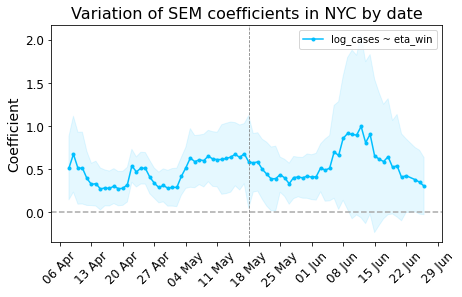

In [31]:
_ = plot_estimate_trend(nyc.D2, [('eta_win', 'log_cases', 'deepskyblue')], marker='.', rolling_win=7)

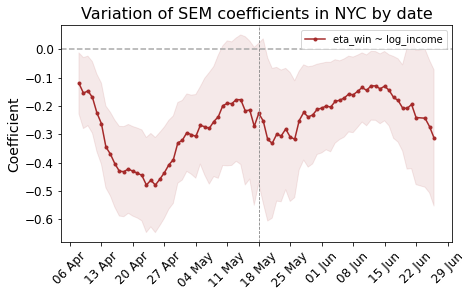

In [32]:
_ = plot_estimate_trend(nyc.D2, [('log_income', 'eta_win', 'brown')], marker='.', rolling_win=7)

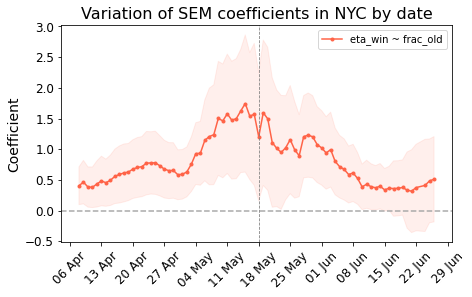

In [33]:
_ = plot_estimate_trend(nyc.D2, [('frac_old', 'eta_win', 'tomato')], marker='.', rolling_win=7)

### NYC:D3

In [34]:
%%time
nyc.D3 = daily_sem(nyc.Xwin, f'''
    eta_win ~ log_income + {frac_vars}
    log_income ~~ frac_poor
    log_income ~~ frac_low_edu
    log_income ~~ frac_black
    log_income ~~ frac_transit
    frac_poor ~~ frac_low_edu
    frac_poor ~~ frac_black
    frac_poor ~~ frac_transit
    frac_low_edu ~~ frac_black
    frac_low_edu ~~ frac_transit
    frac_black ~~ frac_transit
    eta_win =~ time_home_win + prop_home_win + log_tot_cei_win
    prop_home_win ~~ time_home_win
    time_home_win ~~ log_tot_cei_win
    log_tot_cei_win ~~ prop_home_win
    log_cases ~ log_cases_prev + eta_win + frac_old
    ''')
peek(nyc.D3)


Shape: (2640, 8), Memory: 0.834 MB
CPU times: user 1min 15s, sys: 19.1 s, total: 1min 34s
Wall time: 21.6 s


,case,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,2020-04-02,eta_win,~,log_income,-0.217514,0.0600602,-3.62159,0.000292792
1,2020-04-02,eta_win,~,frac_poor,-3.742837,0.474539,-7.88731,3.10862e-15
2,2020-04-02,eta_win,~,frac_old,0.285889,0.223173,1.28102,0.200187


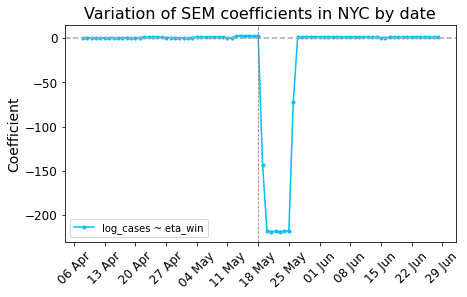

In [35]:
_ = plot_estimate_trend(nyc.D3, [('eta_win', 'log_cases', 'deepskyblue')], marker='.', rolling_win=7)

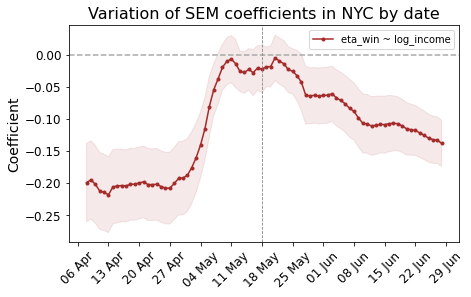

In [36]:
_ = plot_estimate_trend(nyc.D3, [('log_income', 'eta_win', 'brown')], marker='.', rolling_win=7)

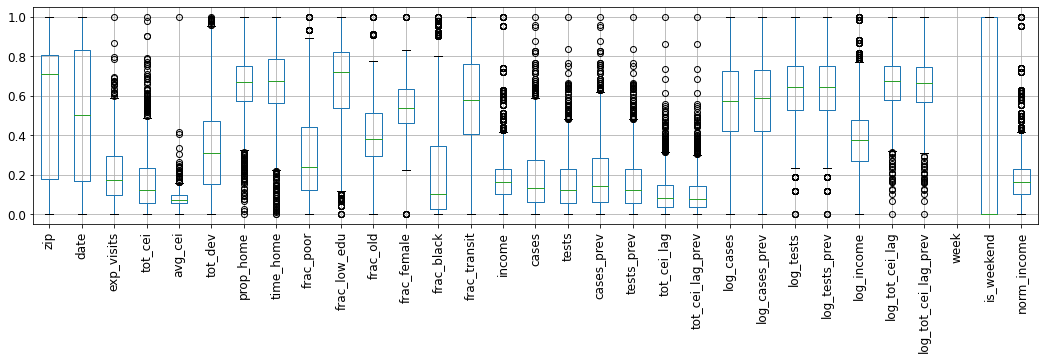

In [37]:
with np.errstate(invalid='ignore'):
    (nyc.X[nyc.X['week'] == g.int2date(200420)]
     .drop(columns=['phase'])
     .apply(g.range_norm)
     .boxplot(figsize=(18, 4), rot=90));

## Phased

### NYC:P1 (form=1, w=14d, log=True)

In [38]:
%%time
nyc.P1 = phased_sem(nyc.Xwin, f'''
        prop_home ~ is_weekend + log_income + {frac_vars}
        time_home ~ is_weekend + log_income + {frac_vars}
        log_tot_cei_win ~ is_weekend + log_income + {frac_vars} + prop_home + time_home
        log_cases_win ~ log_tot_cei_win
        tests ~ log_cases_win
        log_cases ~ log_cases_win + tests + log_tot_cei_win
        ''')
peek(nyc.P1)

Shape: (170, 8), Memory: 0.038 MB
CPU times: user 5.52 s, sys: 1.35 s, total: 6.86 s
Wall time: 1.56 s


,case,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,0,prop_home,~,is_weekend,0.012347,0.003070,4.022051,5.769364e-05
1,0,prop_home,~,log_income,-0.061135,0.009911,-6.168528,6.892871e-10
2,0,prop_home,~,frac_poor,-1.091319,0.077929,-14.004014,0.000000e+00


In [39]:
get_params_table(nyc.P1, imp_pairs=[('prop_home', 'log_income'),
                            ('time_home', 'log_income'),
                            ('log_tot_cei_win', 'log_income'),
                            ('log_cases', 'log_tot_cei_win')], drop_cols=[0])

,phase,1,2,3,4
lval,rval,,,,
prop_home,log_income,-0.086 ***,-0.087 ***,-0.043 ***,-0.038 ***
time_home,log_income,-0.204 ***,-0.193 ***,-0.045 **,-0.120 ***
log_tot_cei_win,log_income,0.247 (.),-0.116 (x),0.169 (x),0.285 ***
log_cases,log_tot_cei_win,0.070 ***,-0.060 ***,-0.085 ***,0.020 *


### NYC:P2 (form=2, w=14d, log=True)

### NYC:P3 (form=3, w=14d, log=True)

### NYC:P4 (form=4, w=14d, log=True)

---
# Illinois

## Prepare data

In [40]:
il.X = read_modelX(il)
peek(il.X)

Shape: (67946, 31), Memory: 16.070 MB


,zip,date,exp_visits,tot_cei,avg_cei,tot_dev,prop_home,time_home,frac_poor,frac_low_edu,...,log_cases,log_cases_prev,log_tests,log_tests_prev,log_income,log_tot_cei_lag,log_tot_cei_lag_prev,week,is_weekend,norm_income
0,60002,2020-03-09,1371,5553.6484,4.050801,3460,0.202832,0.434887,0.521155,0.674858,...,0.001,0.001,0.001,0.001,4.546872,6.092356,6.904498,2020-03-09,0,0.233126
1,60002,2020-03-10,1578,6571.8300,4.164658,3091,0.192432,0.468094,0.521155,0.674858,...,0.001,0.001,0.001,0.001,4.546872,8.860953,6.092356,2020-03-09,0,0.233126
2,60002,2020-03-11,1503,7582.1343,5.044667,2934,0.196934,0.494182,0.521155,0.674858,...,0.001,0.001,0.001,0.001,4.546872,8.916381,8.860953,2020-03-09,0,0.233126


### Get window data

In [41]:
%%time
il.Xwin = get_win_data_daily(il.X)
peek(il.Xwin)

Shape: (64048, 37), Memory: 18.080 MB
CPU times: user 15.2 s, sys: 256 ms, total: 15.4 s
Wall time: 15.7 s


,zip,week,date,exp_visits,tot_cei,avg_cei,tot_dev,prop_home,time_home,frac_poor,...,log_tot_cei_lag,log_tot_cei_lag_prev,is_weekend,norm_income,tot_cei_win,prop_home_win,time_home_win,cases_win,log_tot_cei_win,log_cases_win
0,60002,2020-03-09,2020-03-15,868,632.85940,0.729101,3099,0.339355,0.647813,0.521155,...,6.608757,7.051652,1,0.233126,33860.53570,0.233871,0.505027,0.0,10.430035,0.001
1,60002,2020-03-16,2020-03-16,722,339.77402,0.470601,3093,0.312217,0.557899,0.521155,...,8.622391,6.608757,0,0.233126,28646.66132,0.249498,0.522601,0.0,10.262827,0.001
2,60002,2020-03-16,2020-03-17,577,173.26344,0.300283,3086,0.348235,0.610043,0.521155,...,8.790700,8.622391,0,0.233126,22248.09476,0.271755,0.542879,0.0,10.010057,0.001


## SEM model

## Daily

### IL:D1

In [42]:
%%time
il.D1 = daily_sem(il.Xwin, f'''
    eta_win ~ log_income + {frac_vars}
    log_income ~~ frac_poor
    log_income ~~ frac_old
    log_income ~~ frac_low_edu
    log_income ~~ frac_black
    log_income ~~ frac_transit
    frac_poor ~~ frac_old
    frac_poor ~~ frac_low_edu
    frac_poor ~~ frac_black
    frac_poor ~~ frac_transit
    frac_old ~~ frac_low_edu
    frac_old ~~ frac_black
    frac_old ~~ frac_transit
    frac_low_edu ~~ frac_black
    frac_low_edu ~~ frac_transit
    frac_black ~~ frac_transit
    eta_win =~ log_tot_cei_win + prop_home_win + time_home_win
    prop_home_win ~~ time_home_win
    time_home_win ~~ log_tot_cei_win
    log_tot_cei_win ~~ prop_home_win
    log_cases ~ log_cases_prev + eta_win
    ''', start_date=200418)
peek(il.D1)

LinAlgError in 2020-06-10


LinAlgError in 2020-06-18


LinAlgError in 2020-06-24


LinAlgError in 2020-06-26
LinAlgError in 2020-06-27

Shape: (2278, 8), Memory: 0.719 MB
CPU times: user 1min 43s, sys: 24 s, total: 2min 7s
Wall time: 25 s


,case,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,2020-04-18,eta_win,~,log_income,0.084802,0.593826,0.142806,0.886444
1,2020-04-18,eta_win,~,frac_poor,0.006801,5.18184,0.00131254,0.998953
2,2020-04-18,eta_win,~,frac_old,-0.029755,1.57807,-0.0188551,0.984957


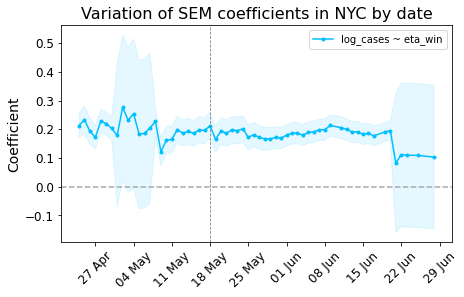

In [43]:
_ = plot_estimate_trend(il.D1, [('eta_win', 'log_cases', 'deepskyblue')], marker='.', rolling_win=7)

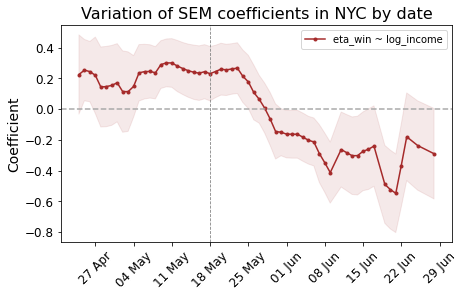

In [44]:
_ = plot_estimate_trend(il.D1, [('log_income', 'eta_win', 'brown')], marker='.', rolling_win=7)

### IL:D2

In [45]:
%%time
il.D2 = daily_sem(il.Xwin, f'''
    eta_win ~ log_income + {frac_vars}
    log_income ~~ frac_poor
    log_income ~~ frac_old
    log_income ~~ frac_low_edu
    log_income ~~ frac_black
    log_income ~~ frac_transit
    frac_poor ~~ frac_old
    frac_poor ~~ frac_low_edu
    frac_poor ~~ frac_black
    frac_poor ~~ frac_transit
    frac_old ~~ frac_low_edu
    frac_old ~~ frac_black
    frac_old ~~ frac_transit
    frac_low_edu ~~ frac_black
    frac_low_edu ~~ frac_transit
    frac_black ~~ frac_transit
    eta_win =~ log_tot_cei_win + time_home_win + prop_home_win
    prop_home_win ~~ time_home_win
    time_home_win ~~ log_tot_cei_win
    log_tot_cei_win ~~ prop_home_win
    log_cases ~ log_cases_prev + eta_win + frac_old
    ''', start_date=200418)
peek(il.D2)

LinAlgError in 2020-06-07


LinAlgError in 2020-06-18


LinAlgError in 2020-06-21


LinAlgError in 2020-06-24
LinAlgError in 2020-06-25

Shape: (2345, 8), Memory: 0.740 MB
CPU times: user 1min 56s, sys: 24.2 s, total: 2min 20s
Wall time: 25.1 s


,case,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,2020-04-18,eta_win,~,log_income,0.084802,0.593826,0.142806,0.886444
1,2020-04-18,eta_win,~,frac_poor,0.006801,5.18184,0.00131254,0.998953
2,2020-04-18,eta_win,~,frac_old,-0.029755,1.57807,-0.0188551,0.984957


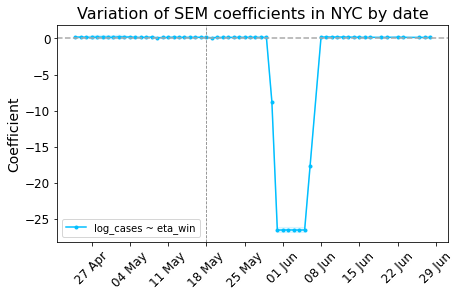

In [46]:
_ = plot_estimate_trend(il.D2, [('eta_win', 'log_cases', 'deepskyblue')], marker='.', rolling_win=7)

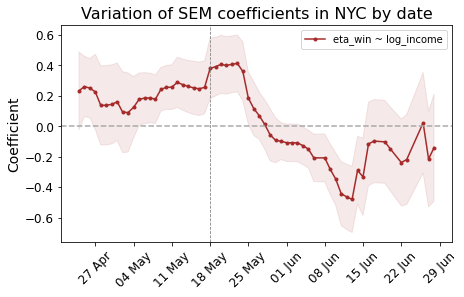

In [47]:
_ = plot_estimate_trend(il.D2, [('log_income', 'eta_win', 'brown')], marker='.', rolling_win=7)

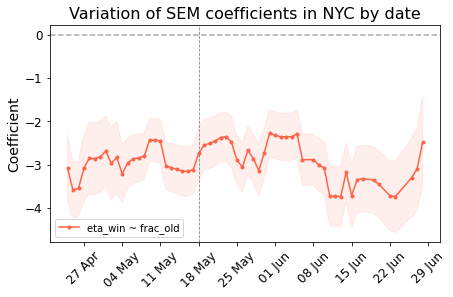

In [48]:
_ = plot_estimate_trend(il.D2, [('frac_old', 'eta_win', 'tomato')], marker='.', rolling_win=7)

### IL:D3

In [49]:
%%time
il.D3 = daily_sem(il.Xwin, f'''
    eta_win ~ log_income + {frac_vars}
    log_income ~~ frac_poor
    log_income ~~ frac_low_edu
    log_income ~~ frac_black
    log_income ~~ frac_transit
    frac_poor ~~ frac_low_edu
    frac_poor ~~ frac_black
    frac_poor ~~ frac_transit
    frac_low_edu ~~ frac_black
    frac_low_edu ~~ frac_transit
    frac_black ~~ frac_transit
    eta_win =~ log_tot_cei_win + time_home_win + prop_home_win
    prop_home_win ~~ time_home_win
    time_home_win ~~ log_tot_cei_win
    log_tot_cei_win ~~ prop_home_win
    log_tests ~ log_cases_prev
    log_cases ~ log_tests + eta_win + frac_old
    ''', start_date=200418)
peek(il.D3)

LinAlgError in 2020-06-26


LinAlgError in 2020-06-28

Shape: (2240, 8), Memory: 0.707 MB
CPU times: user 1min 40s, sys: 25.7 s, total: 2min 6s
Wall time: 26.2 s


,case,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,2020-04-18,eta_win,~,log_income,0.272299,0.19304,1.41058,0.158368
1,2020-04-18,eta_win,~,frac_poor,-7.553241,1.87531,-4.02772,5.63199e-05
2,2020-04-18,eta_win,~,frac_old,-3.388710,0.638276,-5.30916,1.10132e-07


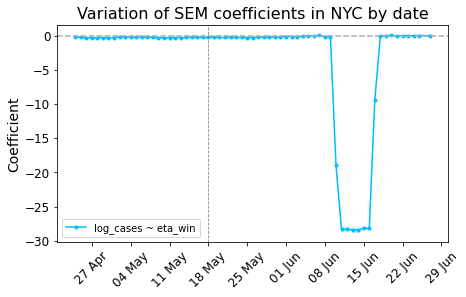

In [50]:
_ = plot_estimate_trend(il.D3, [('eta_win', 'log_cases', 'deepskyblue')], marker='.', rolling_win=7)

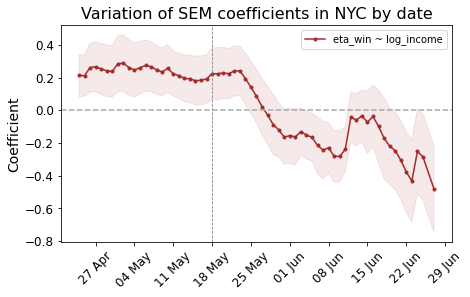

In [51]:
_ = plot_estimate_trend(il.D3, [('log_income', 'eta_win', 'brown')], marker='.', rolling_win=7)

---
# Chicago

## Prepare data

In [52]:
chi.X = read_modelX(chi)
peek(chi.X)

Shape: (27833, 31), Memory: 6.583 MB


,zip,date,exp_visits,tot_cei,avg_cei,tot_dev,prop_home,time_home,frac_poor,frac_low_edu,...,log_cases,log_cases_prev,log_tests,log_tests_prev,log_income,log_tot_cei_lag,log_tot_cei_lag_prev,week,is_weekend,norm_income
0,60002,2020-03-09,1371,5553.6484,4.050801,3460,0.202832,0.434887,0.521155,0.674858,...,0.001,0.001,0.001,0.001,4.546872,6.092356,6.904498,2020-03-09,0,0.217061
1,60002,2020-03-10,1578,6571.8300,4.164658,3091,0.192432,0.468094,0.521155,0.674858,...,0.001,0.001,0.001,0.001,4.546872,8.860953,6.092356,2020-03-09,0,0.217061
2,60002,2020-03-11,1503,7582.1343,5.044667,2934,0.196934,0.494182,0.521155,0.674858,...,0.001,0.001,0.001,0.001,4.546872,8.916381,8.860953,2020-03-09,0,0.217061


### Get window data

In [53]:
%%time
chi.Xwin = get_win_data_daily(chi.X)
peek(chi.Xwin, top=2)

Shape: (26339, 37), Memory: 7.435 MB
CPU times: user 5.89 s, sys: 190 ms, total: 6.08 s
Wall time: 6.13 s


,zip,week,date,exp_visits,tot_cei,avg_cei,tot_dev,prop_home,time_home,frac_poor,...,log_tot_cei_lag,log_tot_cei_lag_prev,is_weekend,norm_income,tot_cei_win,prop_home_win,time_home_win,cases_win,log_tot_cei_win,log_cases_win
0,60002,2020-03-09,2020-03-15,868,632.85940,0.729101,3099,0.339355,0.647813,0.521155,...,6.608757,7.051652,1,0.217061,33860.53570,0.233871,0.505027,0.0,10.430035,0.001
1,60002,2020-03-16,2020-03-16,722,339.77402,0.470601,3093,0.312217,0.557899,0.521155,...,8.622391,6.608757,0,0.217061,28646.66132,0.249498,0.522601,0.0,10.262827,0.001


## SEM model

## Daily

### CHI:D1

In [54]:
%%time
chi.D1 = daily_sem(chi.Xwin, f'''
    eta_win ~ log_income + {frac_vars}
    log_income ~~ frac_poor
    log_income ~~ frac_old
    log_income ~~ frac_low_edu
    log_income ~~ frac_black
    log_income ~~ frac_transit
    frac_poor ~~ frac_old
    frac_poor ~~ frac_low_edu
    frac_poor ~~ frac_black
    frac_poor ~~ frac_transit
    frac_old ~~ frac_low_edu
    frac_old ~~ frac_black
    frac_old ~~ frac_transit
    frac_low_edu ~~ frac_black
    frac_low_edu ~~ frac_transit
    frac_black ~~ frac_transit
    eta_win =~ log_tot_cei_win + time_home_win + prop_home_win
    prop_home_win ~~ time_home_win
    time_home_win ~~ log_tot_cei_win
    log_tot_cei_win ~~ prop_home_win
    log_cases ~ log_cases_prev + eta_win
    ''', start_date=200418)
peek(chi.D1)


Shape: (2448, 8), Memory: 0.773 MB
CPU times: user 1min 46s, sys: 27.3 s, total: 2min 13s
Wall time: 27.4 s


,case,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,2020-04-18,eta_win,~,log_income,-1.005641,0.284226,-3.53817,0.000402911
1,2020-04-18,eta_win,~,frac_poor,0.391153,1.78059,0.219676,0.826124
2,2020-04-18,eta_win,~,frac_old,-0.550959,0.449098,-1.22681,0.219893


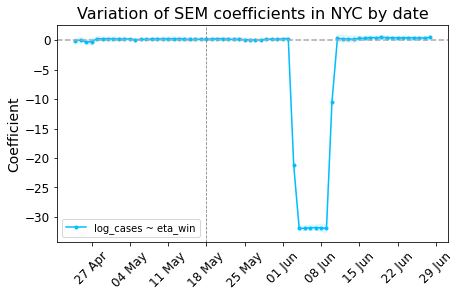

In [55]:
_ = plot_estimate_trend(chi.D1, [('eta_win', 'log_cases', 'deepskyblue')], marker='.', rolling_win=7)

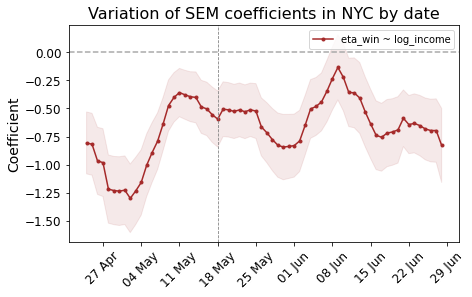

In [56]:
_ = plot_estimate_trend(chi.D1, [('log_income', 'eta_win', 'brown')], marker='.', rolling_win=7)

### CHI:D2

In [57]:
%%time
chi.D2 = daily_sem(chi.Xwin, f'''
    eta_win ~ log_income + {frac_vars}
    log_income ~~ frac_poor
    log_income ~~ frac_old
    log_income ~~ frac_low_edu
    log_income ~~ frac_black
    log_income ~~ frac_transit
    frac_poor ~~ frac_old
    frac_poor ~~ frac_low_edu
    frac_poor ~~ frac_black
    frac_poor ~~ frac_transit
    frac_old ~~ frac_low_edu
    frac_old ~~ frac_black
    frac_old ~~ frac_transit
    frac_low_edu ~~ frac_black
    frac_low_edu ~~ frac_transit
    frac_black ~~ frac_transit
    eta_win =~ log_tot_cei_win + time_home_win + prop_home_win
    prop_home_win ~~ time_home_win
    time_home_win ~~ log_tot_cei_win
    log_tot_cei_win ~~ prop_home_win
    log_cases ~ log_cases_prev + eta_win + frac_old
    ''', start_date=200418)
peek(chi.D2)

LinAlgError in 2020-06-01



Shape: (2485, 8), Memory: 0.784 MB
CPU times: user 1min 56s, sys: 28.3 s, total: 2min 24s
Wall time: 28.9 s


,case,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,2020-04-18,eta_win,~,log_income,-1.005641,0.284226,-3.53817,0.000402911
1,2020-04-18,eta_win,~,frac_poor,0.391153,1.78059,0.219676,0.826124
2,2020-04-18,eta_win,~,frac_old,-0.550959,0.449098,-1.22681,0.219893


In [58]:
chi.D2.loc[chi.D2['Estimate'].where(lambda x: x<-50).dropna().index, 'Estimate'] = 0

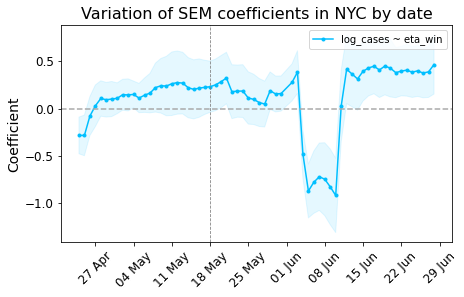

In [59]:
_ = plot_estimate_trend(chi.D2, [('eta_win', 'log_cases', 'deepskyblue')],
                        marker='.', rolling_win=7, max_coeff=1., max_std_err=0.4)

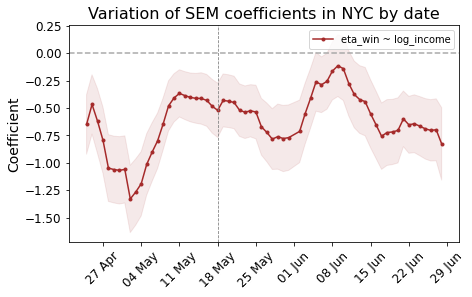

In [60]:
_ = plot_estimate_trend(chi.D2, [('log_income', 'eta_win', 'brown')], marker='.', rolling_win=7)

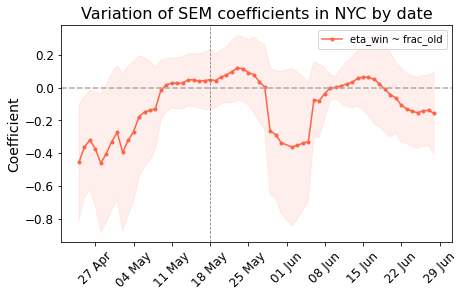

In [61]:
_ = plot_estimate_trend(chi.D2, [('frac_old', 'eta_win', 'tomato')], marker='.', rolling_win=7)

### CHI:D3

In [62]:
%%time
chi.D3 = daily_sem(chi.Xwin, f'''
    eta_win ~ log_income + {frac_vars}
    log_income ~~ frac_poor
    log_income ~~ frac_low_edu
    log_income ~~ frac_black
    log_income ~~ frac_transit
    frac_poor ~~ frac_low_edu
    frac_poor ~~ frac_black
    frac_poor ~~ frac_transit
    frac_low_edu ~~ frac_black
    frac_low_edu ~~ frac_transit
    frac_black ~~ frac_transit
    eta_win =~ log_tot_cei_win + time_home_win + prop_home_win
    prop_home_win ~~ time_home_win
    time_home_win ~~ log_tot_cei_win
    log_tot_cei_win ~~ prop_home_win
    log_tests ~ log_cases_prev
    log_cases ~ log_tests + eta_win + frac_old
    ''', start_date=200418)
peek(chi.D3)


Shape: (2304, 8), Memory: 0.728 MB
CPU times: user 1min 47s, sys: 24.1 s, total: 2min 11s
Wall time: 24.3 s


,case,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,2020-04-18,eta_win,~,log_income,-1.006918,0.284616,-3.53782,0.00040345
1,2020-04-18,eta_win,~,frac_poor,0.351412,1.77852,0.197587,0.843368
2,2020-04-18,eta_win,~,frac_old,-0.558923,0.449253,-1.24412,0.213457


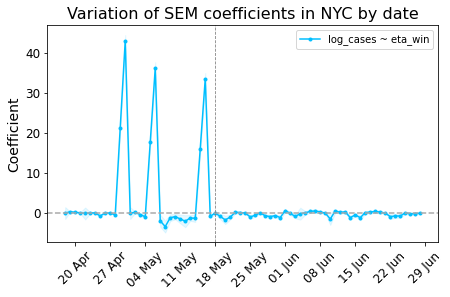

In [63]:
_ = plot_estimate_trend(chi.D3, [('eta_win', 'log_cases', 'deepskyblue')], marker='.', rolling_win=1)

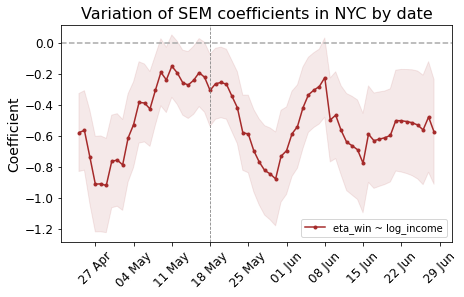

In [64]:
_ = plot_estimate_trend(chi.D3, [('log_income', 'eta_win', 'brown')], marker='.', rolling_win=7)

## Figure for paper

<AxesSubplot:title={'center':'log(Cases) ~ Latent Exposure'}>

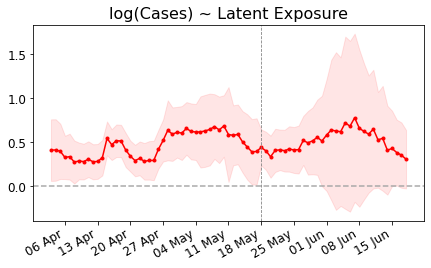

In [65]:
def get_estimate_trend2(params, xvar, yvar, plot=True, color='red', title=None,
                        max_coeff=1.3, max_std_err=1.5, max_pct_diff=50,
                        win=7, marker='.', evts=[('', 200518)]):
    df = (params.query(f'lval == "{yvar}" & rval == "{xvar}"')
          .set_index('case').rename_axis('date')
          .replace('-', np.nan)
          .rename(columns={'Estimate': 'estimate', 'Std. Err': 'std_err'}))
    df['std_err'] = np.clip(df['std_err'], 0, max_std_err)
    df['pct_diff'] = (df['estimate'].diff()/df['estimate'])*100
    adjust_dates = (df[(np.abs(df['pct_diff']) > max_pct_diff) &
                       (np.abs(df['estimate']) > max_coeff)].index)
    for date in adjust_dates:
        idx = df.index.get_loc(date)
        prev, next_ = df.iloc[idx-1], df.iloc[idx+1]
        df.loc[date, 'estimate'] = 0.5*(prev['estimate'] + next_['estimate'])
        df.loc[date, 'std_err'] = 0.5*(prev['std_err'] + next_['std_err'])
    df['estimate'] = df['estimate'].rolling(win).mean().shift(-win)
    df['std_err'] = df['std_err'].rolling(win).mean().shift(-win)
    df['lower'] = df['estimate'] - df['std_err']
    df['upper'] = df['estimate'] + df['std_err']
    df = df[['estimate', 'std_err', 'pct_diff', 'lower', 'upper']].dropna()
    
    if plot:
        fig, ax = plt.subplots(figsize=(7, 4))
        ax.plot(df['estimate'], marker=marker, color=color)
        ax.fill_between(df.index.values, list(df['lower']), list(df['upper']),
                        color=color, alpha=0.1)
        ax.xaxis.set_major_locator(mpl.dates.WeekdayLocator(
            byweekday=0, interval=1))
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d %b'))
        if title is None:
            title = f'{yvar} ~ {xvar}'
        ax.set_title(title)
        ax.set_ylabel('')
        ax.axhline(0, ls='--', color='darkgrey')
        for evt_name, date in evts:
            ax.axvline(g.int2date(date), color='grey', ls='--', lw=0.8)
            ax.text(g.int2date(date), ax.get_ylim()[1], evt_name,
                    ha='right', va='top', rotation=90)
        fig.autofmt_xdate()
        return ax
    return df

get_estimate_trend2(nyc.D2, 'eta_win', 'log_cases', win=7,
                    title='log(Cases) ~ Latent Exposure', plot=True)

CPU times: user 2.43 s, sys: 138 ms, total: 2.57 s
Wall time: 1.25 s


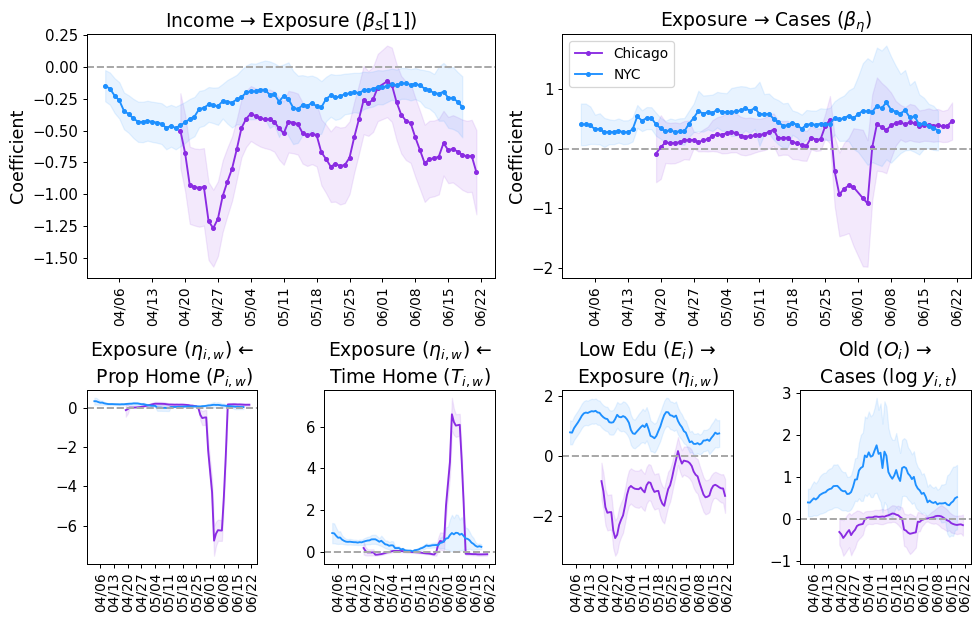

In [66]:
%%time
def plot_sem_params_fig(model='D2', dpi=70):
    def plot_param(df, ax, title, legend=False, marker=None):
        ax.plot(df['estimate'], color=c.color,
                label=c.name if legend else None, marker=marker)
        ax.fill_between(df.index.values, list(df['lower']),
                        list(df['upper']), color=c.color, alpha=0.1)
        ax.xaxis.set_major_locator(mpl.dates.WeekdayLocator(
            byweekday=0, interval=1))
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%d'))
        ax.set_title(title, fontsize=15)
        ax.set_ylabel('')
        ax.tick_params(axis='x', labelrotation=90, labelsize=11)
        ax.axhline(0, ls='--', color='darkgrey')
        if legend:
            ax.legend(loc='upper left', fontsize=11)
            
    fig = plt.figure(figsize=(11, 7), dpi=dpi)
    gs = mpl.gridspec.GridSpec(2, 4, height_ratios=[1.4, 1])
    for c in [chi, nyc]:
        params = getattr(c, model)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            bax1 = plt.subplot(gs[0, :2]) # big axes 1
            bax2 = plt.subplot(gs[0, 2:]) # big axes 2
            sax = [plt.subplot(gs[1, i]) for i in range(4)] # small axes
        
        # income on latent exposure
        plot_param(get_estimate_trend2(params, 'log_income', 'eta_win', plot=False),
                   bax1, 'Income → Exposure ($β_S[1]$)', marker='.')
        bax1.set_ylabel('Coefficient')
        # latent exposure on cases
        plot_param(get_estimate_trend2(params, 'eta_win', 'log_cases', plot=False),
                   bax2, 'Exposure → Cases ($β_{\eta}$)', legend=True, marker='.')
        bax2.set_ylabel('Coefficient')
        
        # prop home on latent exposure
        plot_param(get_estimate_trend2(params, 'eta_win', 'prop_home_win', plot=False),
                   sax[0], 'Exposure ($\eta_{i,w}$) ←\n Prop Home ($P_{i,w}$)')
        # time home on latent exposure
        plot_param(get_estimate_trend2(params, 'eta_win', 'time_home_win', plot=False),
                   sax[1], 'Exposure ($\eta_{i,w}$) ←\nTime Home ($T_{i,w}$)')
        # education on latent exposure
        plot_param(get_estimate_trend2(params, 'frac_low_edu', 'eta_win', plot=False),
                   sax[2], 'Low Edu ($E_i$) →\nExposure ($\eta_{i,w}$)')
        # age on cases
#         plot_param(get_estimate_trend2(params, 'frac_old', 'log_cases',
#                                        max_coeff=5, max_std_err=5, plot=False),
#                    sax[3], 'Old ($O_i$) →\n Cases ($\log\;y_{i,t}$)')
        plot_param(get_estimate_trend2(params, 'frac_old', 'eta_win',
                                       max_coeff=5, max_std_err=5, plot=False),
                   sax[3], 'Old ($O_i$) →\n Cases ($\log\;y_{i,t}$)')
    plt.tight_layout()

plot_sem_params_fig(dpi=90)